### 1. Нейросетевая модель для прогноза теплопроводности (预测热导率 κ 的简单神经网络)

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [3]:
# ===== 1. Генерация "искусственных" данных / 生成一批“虚拟”数据 =====
# Допустим, у нас есть расчёты или эксперименты в диапазонах:

rng = np.random.default_rng(0)

N = 1000  # число образцов / 样本数
T_data = rng.uniform(100.0, 600.0, size=(N, 1))   # температура / 温度
L_data = rng.uniform(10.0, 500.0, size=(N, 1))    # толщина (nm) / 厚度(纳米)

# "Истинная" зависимость (для демонстрации) / 人为设定一个“真实”关系（仅示例）
k0 = 200.0 / (1.0 + 0.0005 * (T_data - 300.0)**2)
L0 = 200.0
kappa_data = k0 * np.exp(-L_data / L0)  # shape (N,1)

# Преобразуем во входной тензор X = [T, L] и выход y = κ  将 T, L 合并成输入张量 X，输出为 κ
X_np = np.hstack([T_data, L_data])     # (N, 2)
y_np = kappa_data                      # (N, 1)

In [4]:
# Масштабирование (нормировка) входов до [0,1] / 简单归一化
T_min, T_max = 100.0, 600.0
L_min, L_max = 10.0, 500.0

X_np_norm = np.empty_like(X_np)
X_np_norm[:, 0] = (X_np[:, 0] - T_min) / (T_max - T_min)  # T -> [0,1]
X_np_norm[:, 1] = (X_np[:, 1] - L_min) / (L_max - L_min)  # L -> [0,1]

# Переводим в torch-тензоры / 转为 torch 张量
X = torch.from_numpy(X_np_norm).float()
y = torch.from_numpy(y_np).float()

# Разделим на train / test / 划分训练集和测试集
n_train = int(0.8 * N)
X_train, y_train = X[:n_train], y[:n_train]
X_test,  y_test  = X[n_train:], y[n_train:]

In [5]:
# ===== 2. Определяем модель / 定义神经网络模型 =====
class KappaNet(nn.Module):
    """
    Небольшая полносвязная сеть для регрессии:
    输入: (T_norm, L_norm) -> 输出: κ
    """
    def __init__(self, in_dim=2, hidden_dim=32, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),                 # скрытый слой 1 / 隐藏层1
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),                 # скрытый слой 2 / 隐藏层2
            nn.Linear(hidden_dim, out_dim)  # выход κ
        )

    def forward(self, x):
        return self.net(x)


model = KappaNet()
print(model)

KappaNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [6]:
# ===== 3. Функция потерь и оптимизатор / 损失函数 & 优化器 =====
criterion = nn.MSELoss()                 # MSE для регрессии / 回归任务用 MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam 优化器

In [7]:
# ===== 4. Цикл обучения / 训练循环 =====
n_epochs = 2000
batch_size = 64

for epoch in range(1, n_epochs + 1):
    # --- mini-batch SGD ---
    perm = torch.randperm(n_train)
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    for start in range(0, n_train, batch_size):
        end = start + batch_size
        xb = X_train_shuffled[start:end]
        yb = y_train_shuffled[start:end]

        # forward
        y_pred = model(xb)
        loss = criterion(y_pred, yb)

        # backward + обновление / 反向传播 + 更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 每 200 轮 打印一次训练和测试误差
    if epoch % 200 == 0:
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train).item()
            test_loss  = criterion(model(X_test),  y_test).item()
        print(f"Epoch {epoch:4d} | train MSE = {train_loss:.4f}, "
              f"test MSE = {test_loss:.4f}")

Epoch  200 | train MSE = 164.2793, test MSE = 161.6122
Epoch  400 | train MSE = 19.4473, test MSE = 18.6117
Epoch  600 | train MSE = 3.3217, test MSE = 2.5283
Epoch  800 | train MSE = 1.3275, test MSE = 1.6579
Epoch 1000 | train MSE = 0.6756, test MSE = 1.2530
Epoch 1200 | train MSE = 0.4855, test MSE = 1.1147
Epoch 1400 | train MSE = 0.4262, test MSE = 0.9552
Epoch 1600 | train MSE = 0.3911, test MSE = 0.8280
Epoch 1800 | train MSE = 0.3876, test MSE = 0.7718
Epoch 2000 | train MSE = 0.3660, test MSE = 0.7067


In [8]:
# ===== 5. Пример прогноза / 示例：做一次预测 =====
def predict_kappa(T_val, L_val):
    """
    Прогноз κ для заданных T (K) и L (nm).
    给定温度 T(K) 和厚度 L(nm)，预测热导率 κ
    """
    # нормировка / 归一化
    T_norm = (T_val - T_min) / (T_max - T_min)
    L_norm = (L_val - L_min) / (L_max - L_min)
    x = torch.tensor([[T_norm, L_norm]], dtype=torch.float32)
    with torch.no_grad():
        k_pred = model(x).item()
    return k_pred

T_example = 300.0
L_example = 100.0
k_example = predict_kappa(T_example, L_example)
print(f"Пример: T = {T_example} K, L = {L_example} nm -> "
      f"предсказанная κ ≈ {k_example:.2f}")

Пример: T = 300.0 K, L = 100.0 nm -> предсказанная κ ≈ 121.75


### 2. Одномерное уравнение теплопроводности: явная КР-схема (FDM) (一维热传导方程：显式有限差分法)

Рассмотрим одномерное уравнение теплопроводности (一维热传导方程)

$$
\frac{\partial T}{\partial t}
= \alpha\,\frac{\partial^2 T}{\partial x^2},
\qquad x\in(0,1),\ t>0,
$$
 
- $T(x,t)$ — температура (温度)  
- $\alpha$ — коэффициент температуропроводности (热扩散系数)  

**Граничные условия** 边界条件  

$$
T(t,0)=0,\qquad T(t,1)=1.
$$

Левая граница фиксирована в 0, правая — в 1 (左边界固定为 0，右边界固定为 1)

**Начальное условие** 初始条件  

$$
T(0,x)=0, \qquad 0 < x < 1.
$$

Температура сначала равна нулю (初始温度都为零)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# ----- Параметры задачи / 问题参数 -----
L = 1.0          # длина стержня / 杆长
nx = 51          # узлов по x / x 方向网格点数
dx = L / (nx - 1)
alpha = 1.0      # температуропроводность / 热扩散系数
# Условие устойчивости для явной схемы: gamma <= 0.5
dt = 0.5 * dx**2 / alpha
gamma = alpha * dt / dx**2

print(f"dx = {dx:.4f}, dt = {dt:.4e}, gamma = {gamma:.4f}")

dx = 0.0200, dt = 2.0000e-04, gamma = 0.5000


In [11]:
nt = 2000                 # шагов по времени / 时间步数

# ----- Инициализация поля T / 温度场初始化 -----
x = np.linspace(0, L, nx)
T = np.zeros(nx)          # начальное условие T(0,x)=0
T[0] = 0.0                # левая граница / 左边界
T[-1] = 1.0               # правая граница / 右边界

In [12]:
# Для визуализации сохраним несколько "срезов" по времени 为可视化保存几个时刻的温度分布

snap_times = [50, 500, 2000]
snapshots = {}

snapshots[0] = T.copy()

# ----- Основной цикл FDM / 显式差分主循环 -----
for n in range(1, nt + 1):
    T_old = T.copy()

    # внутренние точки / 内点
    T[1:-1] = T_old[1:-1] + gamma * (
        T_old[2:] - 2.0 * T_old[1:-1] + T_old[:-2]
    )

    # граничные условия / 边界条件
    T[0] = 0.0
    T[-1] = 1.0

    if n in snap_times:
        snapshots[n] = T.copy()

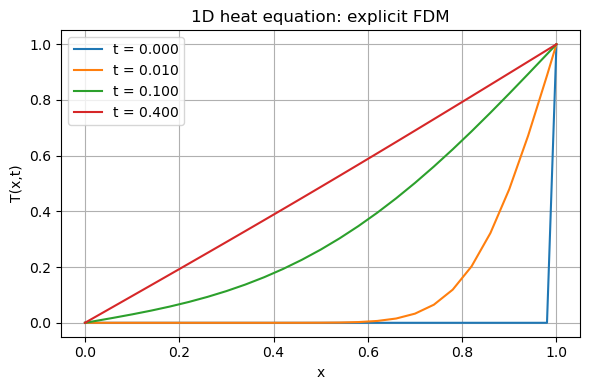

In [13]:
# ----- Визуализация / 可视化 -----
plt.figure(figsize=(6, 4))
for t_step, T_snap in snapshots.items():
    label = f"t = {t_step*dt:.3f}"
    plt.plot(x, T_snap, label=label)

plt.xlabel("x")
plt.ylabel("T(x,t)")
plt.title("1D heat equation: explicit FDM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Одномерное уравнение теплопроводности: решение с помощью PINN (一维热传导方程：使用 PINN 求解)

Рассмотрим ту же одномерную задачу теплопроводности (一维热传导问题) 

$$
T_t - \alpha T_{xx} = 0, 
\qquad x\in(0,1),\ t\in(0,1),
$$

с граничными и начальными условиями (边界条件与初始条件)

$$
T(t,0)=0,\qquad
T(t,1)=1,\qquad
T(0,x)=0.
$$

Мы строим нейросеть $T_\theta(x,t)$, принимающую на вход $(x,t)$ и выдающую приближение температуры.  
我们构建一个神经网络 $T_\theta(x,t)$，输入为 $(x,t)$，输出为近似温度。

С помощью **автоматического дифференцирования (autograd)** получаем $T_t, T_{xx}$  
通过 **自动求导（autograd）** 获取 $T_t, T_{xx}$  


На их основе формируем невязку PDE:  
由此构造 PDE 残差损失：

$$
\mathcal{L}_{\text{eq}} = \| T_t - \alpha T_{xx} \|^2.
$$

Кроме того, добавляются дополнительные части функции потерь:  
此外，还需要加入其它损失项：

- **граничные условия (BC) / 边界条件损失**  
- **начальное условие (IC) / 初始条件损失**

**Полная функция потерь  完整损失函数**  

$$
\mathcal{L}=\mathcal{L}_{\text{eq}}+\mathcal{L}_{\text{bc}}+\mathcal{L}_{\text{ic}}.
$$

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Устройство (CPU / GPU) / 选择设备 -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [15]:
# ----- Параметры уравнения / 方程参数 -----
alpha = 1.0  # температуропроводность / 热扩散系数

# ----- Область задачи / 计算区域 -----
# x ∈ [0,1], t ∈ [0,1]
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

In [16]:
# ----- Определим PINN-сеть / 定义 PINN 网络 -----
class PINN(nn.Module):
    """
    Простейшая полносвязная сеть: (x,t) -> T_theta(x,t)
    """
    def __init__(self, in_dim=2, hidden_dim=32, n_hidden=3, out_dim=1):
        super().__init__()
        layers = []
        # Входной слой / 输入层
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.Tanh())
        # Скрытые слои / 隐藏层
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        # Выходной слой / 输出层
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        # x,t: shape (N,1) -> объединяем в (N,2)
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

model = PINN().to(device)

In [17]:
# ================== Точки для обучения / 采样训练点 ==================

# 1) Внутренние точки для PDE (collocation points)
#    用于 PDE 残差的内部点
N_f = 2000
x_f = torch.rand(N_f, 1) * (x_max - x_min) + x_min
t_f = torch.rand(N_f, 1) * (t_max - t_min) + t_min

# 2) Граничные точки: x=0 и x=1 / 边界点
N_b = 200
t_b = torch.rand(N_b, 1) * (t_max - t_min) + t_min
x_b0 = torch.zeros(N_b, 1)           # x=0 -> T=0
x_b1 = torch.ones(N_b, 1) * x_max    # x=1 -> T=1

T_b0 = torch.zeros(N_b, 1)  # BC at x=0 / 边界条件：x=0
T_b1 = torch.ones(N_b, 1)   # BC at x=1 / 边界条件：x=1

# 3) Начальные точки: t=0 / 初始点
N_i = 200
x_i = torch.rand(N_i, 1) * (x_max - x_min) + x_min
t_i = torch.zeros(N_i, 1)
T_i = torch.zeros(N_i, 1)   # IC: T(0,x)=0 / 初始条件

# Переносим на устройство / 放到设备上
x_f, t_f = x_f.to(device), t_f.to(device)
x_b0, t_b = x_b0.to(device), t_b.to(device)
x_b1 = x_b1.to(device)
T_b0, T_b1 = T_b0.to(device), T_b1.to(device)
x_i, t_i, T_i = x_i.to(device), t_i.to(device), T_i.to(device)

# ----- Оптимизатор / 优化器 -----
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# ================== Функция потерь PINN / PINN 损失函数 ==================
def pinn_loss():
    # 1) PDE residual: T_t - alpha * T_xx = 0
    #    PDE 残差项

    # Разрешаем автодифф по x_f, t_f / 打开对 x_f, t_f 的求导
    x_f.requires_grad_(True)
    t_f.requires_grad_(True)

    # Прямой проход: T(x,t) / 前向：T(x,t)
    T_f = model(x_f, t_f)

    # dT/dt
    T_t = torch.autograd.grad(
        T_f, t_f,
        grad_outputs=torch.ones_like(T_f),
        retain_graph=True,
        create_graph=True
    )[0]

    # dT/dx
    T_x = torch.autograd.grad(
        T_f, x_f,
        grad_outputs=torch.ones_like(T_f),
        retain_graph=True,
        create_graph=True
    )[0]

    # d2T/dx2
    T_xx = torch.autograd.grad(
        T_x, x_f,
        grad_outputs=torch.ones_like(T_x),
        retain_graph=True,
        create_graph=True
    )[0]

    # PDE residual: T_t - alpha T_xx = 0
    f_pde = T_t - alpha * T_xx
    loss_eq = torch.mean(f_pde**2)   # MSE по PDE / PDE 残差平方

    # 2) Loss по граничным условиям / 边界损失
    T_b0_pred = model(x_b0, t_b)     # x=0
    T_b1_pred = model(x_b1, t_b)     # x=1
    loss_bc = torch.mean((T_b0_pred - T_b0)**2) + \
              torch.mean((T_b1_pred - T_b1)**2)

    # 3) Loss по начальному условию / 初始条件损失
    T_i_pred = model(x_i, t_i)       # t=0
    loss_ic = torch.mean((T_i_pred - T_i)**2)

    # Итоговая loss: можно просто суммировать (равные веса)
    # 总损失：三项简单相加
    loss = loss_eq + loss_bc + loss_ic
    return loss, loss_eq, loss_bc, loss_ic

In [19]:
# ================== Цикл обучения / 训练循环 ==================
n_epochs = 10000

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, loss_eq, loss_bc, loss_ic = pinn_loss()
    loss.backward()
    optimizer.step()

    # Каждые 500 эпох печатаем статистику / 每 500 轮打印一次
    if epoch % 500 == 0:
        print(
            f"Epoch {epoch:5d}: "
            f"loss = {loss.item():.4e}, "
            f"eq = {loss_eq.item():.4e}, "
            f"bc = {loss_bc.item():.4e}, "
            f"ic = {loss_ic.item():.4e}"
        )

Epoch   500: loss = 6.1483e-02, eq = 4.6103e-03, bc = 3.0702e-02, ic = 2.6170e-02
Epoch  1000: loss = 3.4213e-02, eq = 1.6436e-03, bc = 1.8463e-02, ic = 1.4106e-02
Epoch  1500: loss = 2.4713e-02, eq = 2.0459e-03, bc = 1.2685e-02, ic = 9.9825e-03
Epoch  2000: loss = 1.9749e-02, eq = 1.4053e-03, bc = 1.0209e-02, ic = 8.1340e-03
Epoch  2500: loss = 1.6577e-02, eq = 1.1317e-03, bc = 8.8802e-03, ic = 6.5653e-03
Epoch  3000: loss = 1.4046e-02, eq = 8.2636e-04, bc = 7.9632e-03, ic = 5.2564e-03
Epoch  3500: loss = 1.2470e-02, eq = 6.7818e-04, bc = 7.2344e-03, ic = 4.5575e-03
Epoch  4000: loss = 1.1422e-02, eq = 5.8355e-04, bc = 6.7063e-03, ic = 4.1324e-03
Epoch  4500: loss = 1.0537e-02, eq = 5.2027e-04, bc = 6.2967e-03, ic = 3.7201e-03
Epoch  5000: loss = 9.8106e-03, eq = 4.8007e-04, bc = 5.9521e-03, ic = 3.3785e-03
Epoch  5500: loss = 9.1022e-03, eq = 3.9936e-04, bc = 5.5726e-03, ic = 3.1303e-03
Epoch  6000: loss = 8.4727e-03, eq = 3.1434e-04, bc = 5.2934e-03, ic = 2.8650e-03
Epoch  6500: los

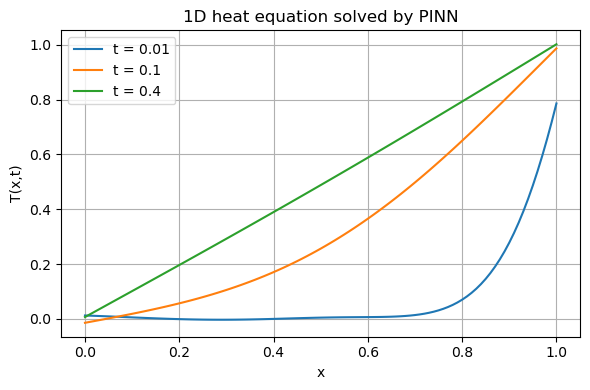

In [20]:
# ================== Визуализация результата / 结果可视化 ==================
model.eval()
with torch.no_grad():
    # Фиксируем несколько срезов по времени / 选择几条 t 的截面
    xs = torch.linspace(x_min, x_max, 101).view(-1, 1).to(device)
    times = [0.01, 0.1, 0.4]

    plt.figure(figsize=(6, 4))
    for t_val in times:
        ts = torch.ones_like(xs) * t_val
        Ts = model(xs, ts).cpu().numpy().flatten()
        plt.plot(xs.cpu().numpy(), Ts, label=f"t = {t_val}")

    plt.xlabel("x")
    plt.ylabel("T(x,t)")
    plt.title("1D heat equation solved by PINN")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()